# Test Your Algorithm

## Instructions
1. From the **Pulse Rate Algorithm** Notebook you can do one of the following:
   - Copy over all the **Code** section to the following Code block.
   - Download as a Python (`.py`) and copy the code to the following Code block.
2. In the bottom right, click the <span style="color:blue">Test Run</span> button. 

### Didn't Pass
If your code didn't pass the test, go back to the previous Concept or to your local setup and continue iterating on your algorithm and try to bring your training error down before testing again.

### Pass
If your code passes the test, complete the following! You **must** include a screenshot of your code and the Test being **Passed**. Here is what the starter filler code looks like when the test is run and should be similar. A passed test will include in the notebook a green outline plus a box with **Test passed:** and in the Results bar at the bottom the progress bar will be at 100% plus a checkmark with **All cells passed**.
![Example](example.png)

1. Take a screenshot of your code passing the test, make sure it is in the format `.png`. If not a `.png` image, you will have to edit the Markdown render the image after Step 3. Here is an example of what the `passed.png` would look like 
2. Upload the screenshot to the same folder or directory as this jupyter notebook.
3. Rename the screenshot to `passed.png` and it should show up below.
![Passed](passed.png)
4. Download this jupyter notebook as a `.pdf` file. 
5. Continue to Part 2 of the Project. 

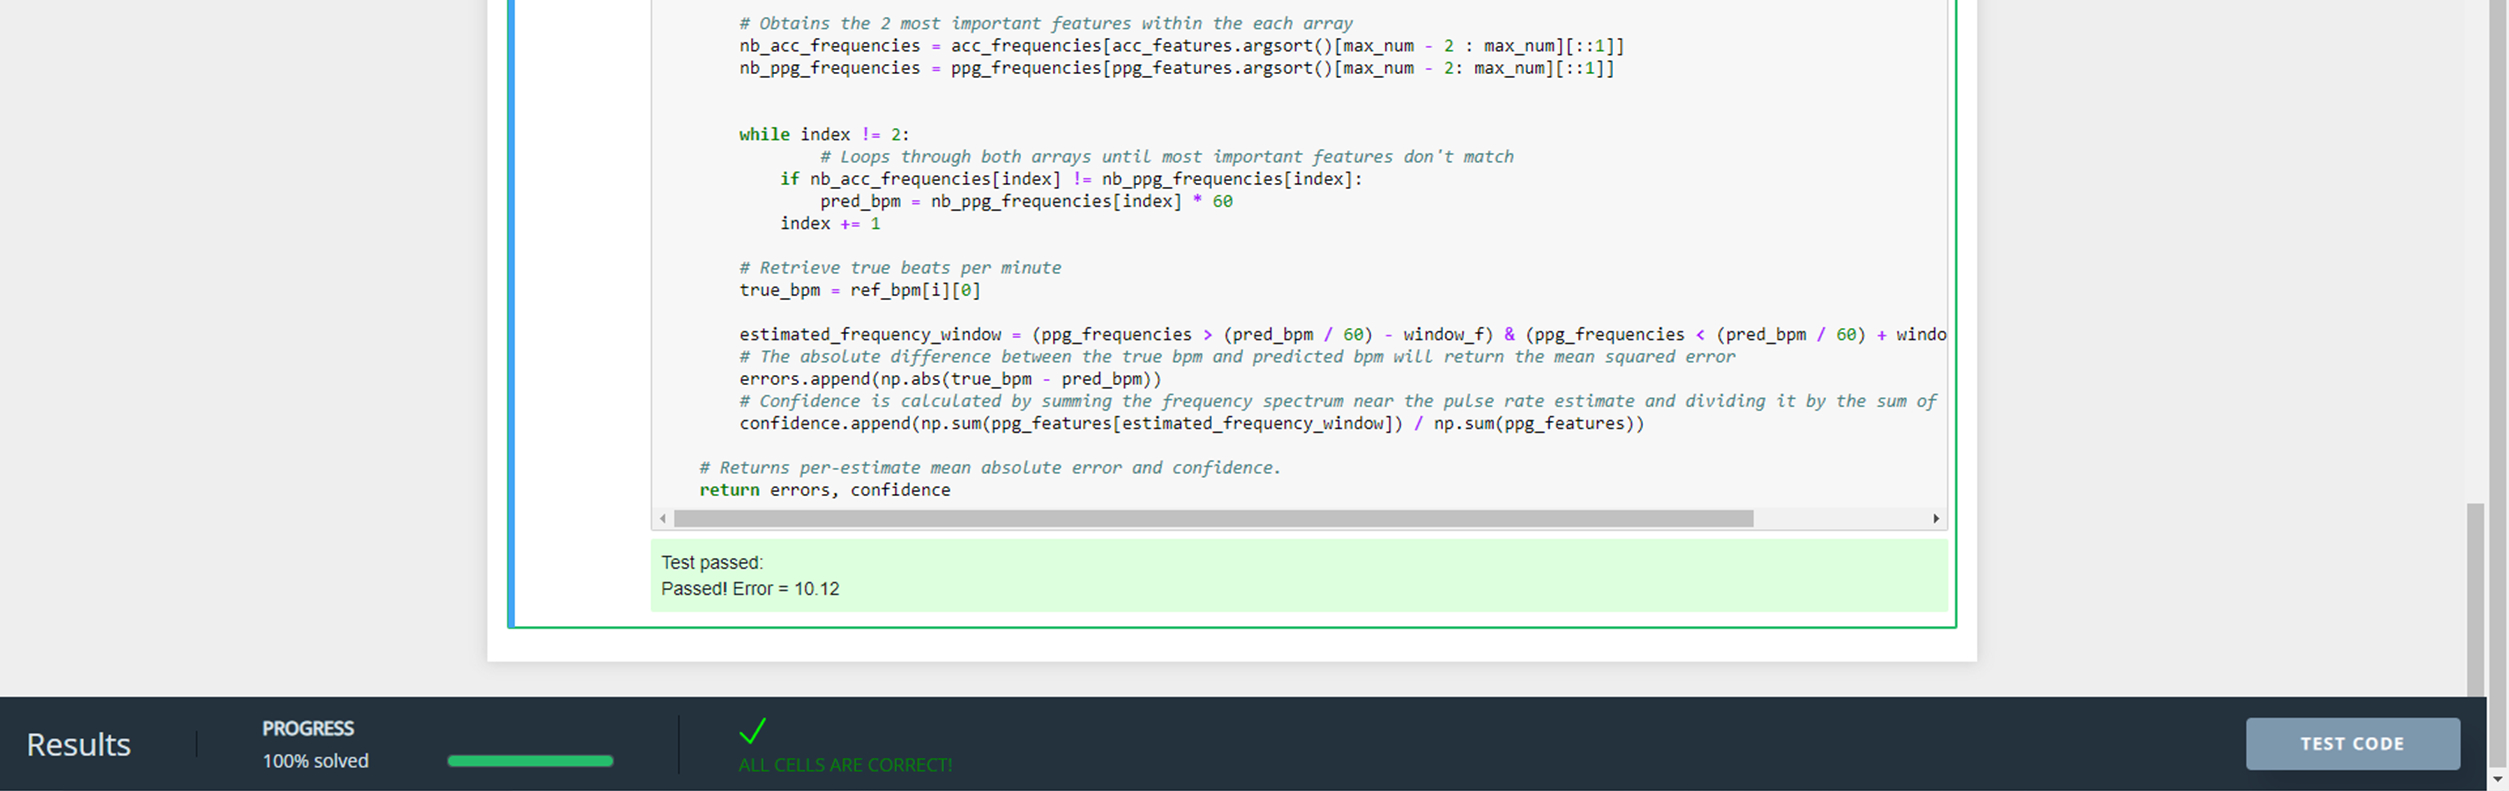

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt

fs = 125


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def BandpassFilter(signal):
    """
    Filters the signal between 40 and 240 Hz
        
    Returns: filtered signal 
    """
    band_pass=(40/60.0, 240/60.0)
    b, a = scipy.signal.butter(3, band_pass, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Runs the pulse rate algorithm by:
    
    - retrieving Troika datasets
    - obtaining spectrogram data
    - filtering the ppg and acc signals
    - finding most important features
    - calculates beats per minute (bpm)
    - computes confidence and errors. 
    
    Returns: Mean squared error of predictions. 
    """
    
    errors, confidence = [], []
    pred_bpm = 0
    window_f = 40 / 60
    
    # Loading Troika Data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_bpm  = sp.io.loadmat(ref_fl)['BPM0']
    
    # Computes the magnitude of the acceleration using X,Y, Z acceleration values
    acc_mag = np.sqrt(accx ** 2 + accy ** 2 + accz ** 2)
    
    # Applies a band pass filter between 40Hz and 240Hz
    filtered_ppg_signal = BandpassFilter(ppg)
    filtered_acc_signal = BandpassFilter(acc_mag)
    
    # Obtains the spectogram data of the filtered signal after bandpass filter has been applied 
    ppg_spectogram_data, ppg_frequencies, _, _ = plt.specgram(filtered_ppg_signal, Fs = fs, NFFT=8 * fs, noverlap=6*fs)
    acc_spectogram_data, acc_frequencies, _, _ = plt.specgram(filtered_acc_signal, Fs = fs, NFFT=8 * fs, noverlap=6* fs)
    
    for i in range(acc_spectogram_data.shape[1]):
        # Sets default index value to zero after each loop
        index = 0 
        
        acc_features = acc_spectogram_data[:, i]
        ppg_features = ppg_spectogram_data[:, i]
        
        # Obtains the most important features within the acceleration and ppg signals
        dominant_accmag_freq = acc_frequencies[np.argmax(acc_features)]
        dominant_ppg_freq = ppg_frequencies[np.argmax(ppg_features)]
        
        # Computes the number of features obtained
        max_num = len(acc_features)
        
        # Obtains the 2 most important features within the each array
        nb_acc_frequencies = acc_frequencies[acc_features.argsort()[max_num - 2 : max_num][::1]]
        nb_ppg_frequencies = ppg_frequencies[ppg_features.argsort()[max_num - 2: max_num][::1]]
        
            
        while index != 2:
                # Loops through both arrays until most important features don't match
            if nb_acc_frequencies[index] != nb_ppg_frequencies[index]:
                pred_bpm = nb_ppg_frequencies[index] * 60
            index += 1
    
        # Retrieve true beats per minute
        true_bpm = ref_bpm[i][0]
        
        estimated_frequency_window = (ppg_frequencies > (pred_bpm / 60) - window_f) & (ppg_frequencies < (pred_bpm / 60) + window_f)
        # The absolute difference between the true bpm and predicted bpm will return the mean squared error
        errors.append(np.abs(true_bpm - pred_bpm))
        # Confidence is calculated by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
        confidence.append(np.sum(ppg_features[estimated_frequency_window]) / np.sum(ppg_features))
        
    # Returns per-estimate mean absolute error and confidence.
    return errors, confidence